In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, RFECV, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

from db.__init__ import LOCAL_CONNECTION_URI


In [2]:
def fetch_clean_data() -> pd.DataFrame:
    Q_GET_CLEAN_DATA = """
        SELECT * FROM offers_clean;
    """
    engine = create_engine(LOCAL_CONNECTION_URI)
    Session = sessionmaker(bind=engine)
    with Session() as session:
        data = session.execute(text(Q_GET_CLEAN_DATA)).fetchall()
        df = pd.DataFrame(data)
        df.index = df["id"]
        df.drop(columns=["id"], inplace=True)
        return df

In [3]:
df = fetch_clean_data()
df.head()

,url_id,price,area,rooms,floor,floor_num,construction_status,ownership,build_year,balcony,...,lift,garage,market,offer_type,city,voivodeship,longitude,latitude,created_at,modified_at
id,,,,,,,,,,,,,,,,,,,,,
154676,431834,518600,65.00,4,3,NaN,to_completion,full_ownership,NaN,1,...,1,1,primary,mieszkanie,Gdańsk,pomorskie,18.616291,54.323699,2024-11-04 12:08:42,2024-11-06 12:09:42
154677,431621,1055274,63.09,3,5,7.0,to_completion,full_ownership,2025.0,1,...,1,1,primary,mieszkanie,Kraków,małopolskie,19.971010,50.048850,2024-10-31 13:17:55,2024-10-31 13:18:44
154678,430425,380900,27.50,1,9,10.0,to_completion,full_ownership,2024.0,1,...,1,1,primary,mieszkanie,Wrocław,dolnośląskie,16.996721,51.130219,2024-08-19 23:10:29,2024-11-03 21:23:41
154679,430286,660000,57.16,3,3,3.0,ready_to_use,full_ownership,2019.0,1,...,1,1,secondary,mieszkanie,Oleśnica,dolnośląskie,17.369884,51.213810,2024-11-03 13:04:26,2024-11-03 13:33:12
154680,431547,1150000,42.61,2,0,10.0,ready_to_use,full_ownership,2023.0,0,...,0,1,secondary,mieszkanie,Kraków,małopolskie,19.976430,50.055932,2024-11-03 12:35:43,2024-11-04 08:47:48


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155659 entries, 154676 to 310334
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   url_id               155659 non-null  int64         
 1   price                155659 non-null  int64         
 2   area                 155659 non-null  float64       
 3   rooms                155659 non-null  int64         
 4   floor                155659 non-null  int64         
 5   floor_num            147625 non-null  float64       
 6   construction_status  155659 non-null  object        
 7   ownership            155659 non-null  object        
 8   build_year           120903 non-null  float64       
 9   balcony              155659 non-null  int64         
 10  terrace              155659 non-null  int64         
 11  lift                 155659 non-null  int64         
 12  garage               155659 non-null  int64         
 13  market        

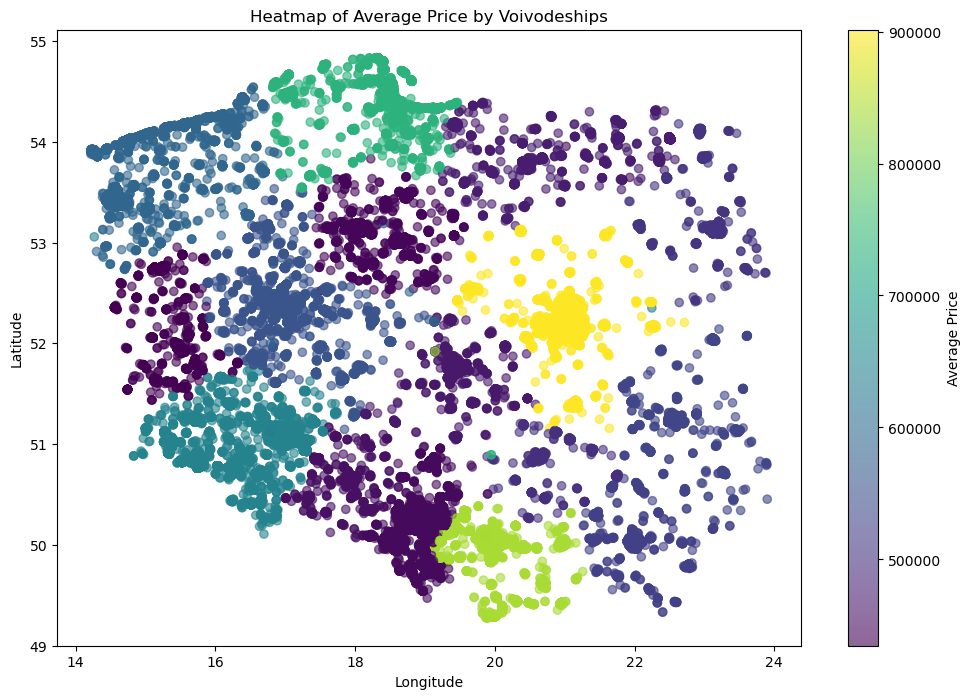

In [5]:
df_temp = df.groupby(['voivodeship']).agg({'price': 'mean'}).reset_index()
df_grouped = pd.merge(df, df_temp, on="voivodeship", how="left", suffixes=('', '_city'))

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_grouped['longitude'], df_grouped['latitude'], c=df_grouped['price_city'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Average Price')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Heatmap of Average Price by Voivodeships')
plt.show()

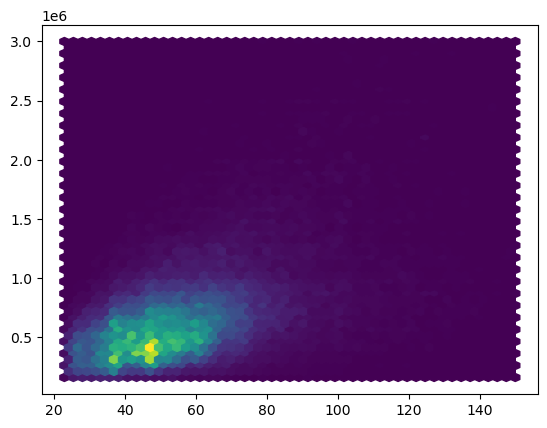

In [6]:
plt.hexbin(df["area"], df["price"], gridsize=50, cmap="viridis")
plt.show()

In [7]:
df["pricem2"] = df["price"] / df["area"]

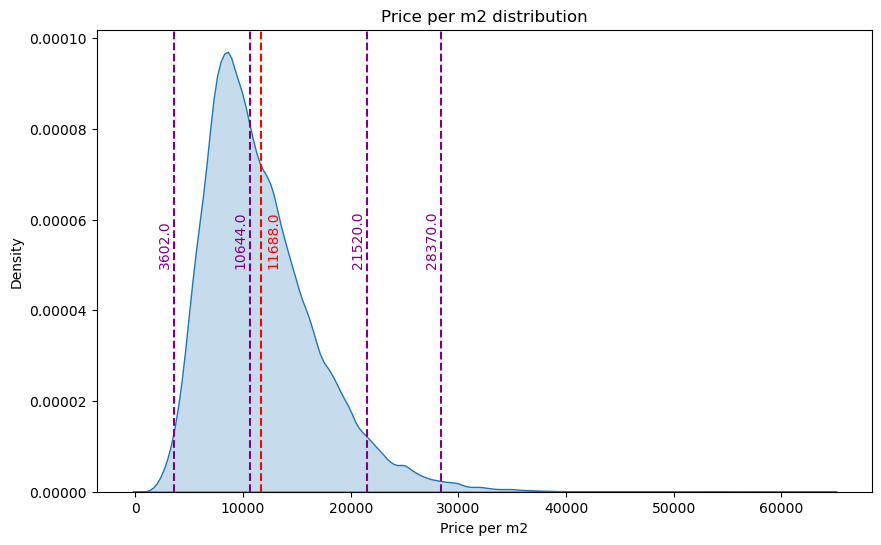

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
avg = df["pricem2"].mean()

sns.kdeplot(df["pricem2"], fill=True, ax=ax)
for q in [0.01, 0.5, 0.95, 0.99]:
    quantile = df["pricem2"].quantile(q)
    ax.axvline(quantile, color="purple", linestyle="--")
    ax.text(quantile-1500, 0.00005, f"{round(quantile, 0)}", rotation=90, color="purple")
ax.axvline(avg, color="red", linestyle="--")
ax.text(avg+500, 0.00005, f"{round(avg, 0)}", rotation=90, color="red")
ax.set_title("Price per m2 distribution")
ax.set_xlabel("Price per m2")
plt.show()

In [9]:
df_filtered_quantiles = df[(df["pricem2"] > df["pricem2"].quantile(0.01)) & (df["pricem2"] < 40000)]

df_temp = df.groupby(["voivodeship", "construction_status"]).agg(mean_pricem2=("pricem2", "mean"), std_pricem2=("pricem2", "std"), count_pricem2=("pricem2", "count")).reset_index()
df_pricem2_voivodeship = pd.merge(df, df_temp, on=["voivodeship", "construction_status"], how="left", suffixes=("", "_v"))
df_filtered_agg = df_pricem2_voivodeship[(df_pricem2_voivodeship["pricem2"] > df_pricem2_voivodeship["mean_pricem2"] - 1.5 * df_pricem2_voivodeship["std_pricem2"])]

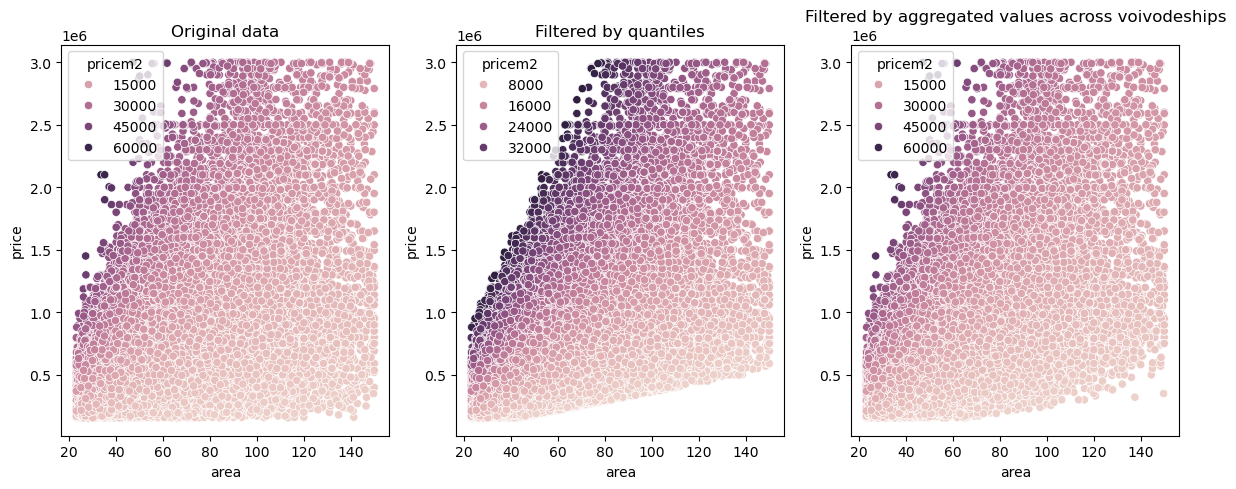

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
sns.scatterplot(df, x="area", y="price", ax=ax[0], hue="pricem2")
ax[0].set_title("Original data")
sns.scatterplot(df_filtered_quantiles, x="area", y="price", ax=ax[1], hue="pricem2")
ax[1].set_title("Filtered by quantiles")
sns.scatterplot(df_filtered_agg, x="area", y="price", ax=ax[2], hue="pricem2")
ax[2].set_title("Filtered by aggregated values across voivodeships")
plt.tight_layout()
plt.show()

In [22]:
df["balcony_high_floor"] = np.where((df["balcony"] == 1) & (df["floor"] > 5), 1, 0)
df["old_building"] = np.where((df["build_year"] < 2000) | (df["construction_status"] == "to_renovation"), 1, 0)
df["ready_to_move_in"] = np.where(df["construction_status"] == "ready_to_use", 1, 0)
df["full_ownership"] = np.where(df["ownership"] == "full_ownership", 1, 0)
df["num_accomodities"] = df["balcony"] + df["garage"] + df["lift"] + df["terrace"]
df["build_year_bucket"] = np.where(df["build_year"] < 1900, "before_1900", np.where(df["build_year"] < 1950, "1900-1950", np.where(df["build_year"] < 2000, "1950-2000", "after_2000")))
df["build_year_bucketnum"] = np.where(df["build_year"] < 1900, 0, np.where(df["build_year"] < 1950, 1, np.where(df["build_year"] < 2000, 2, 3)))
df["floor_num-floor"] = df["floor_num"] - df["floor"]

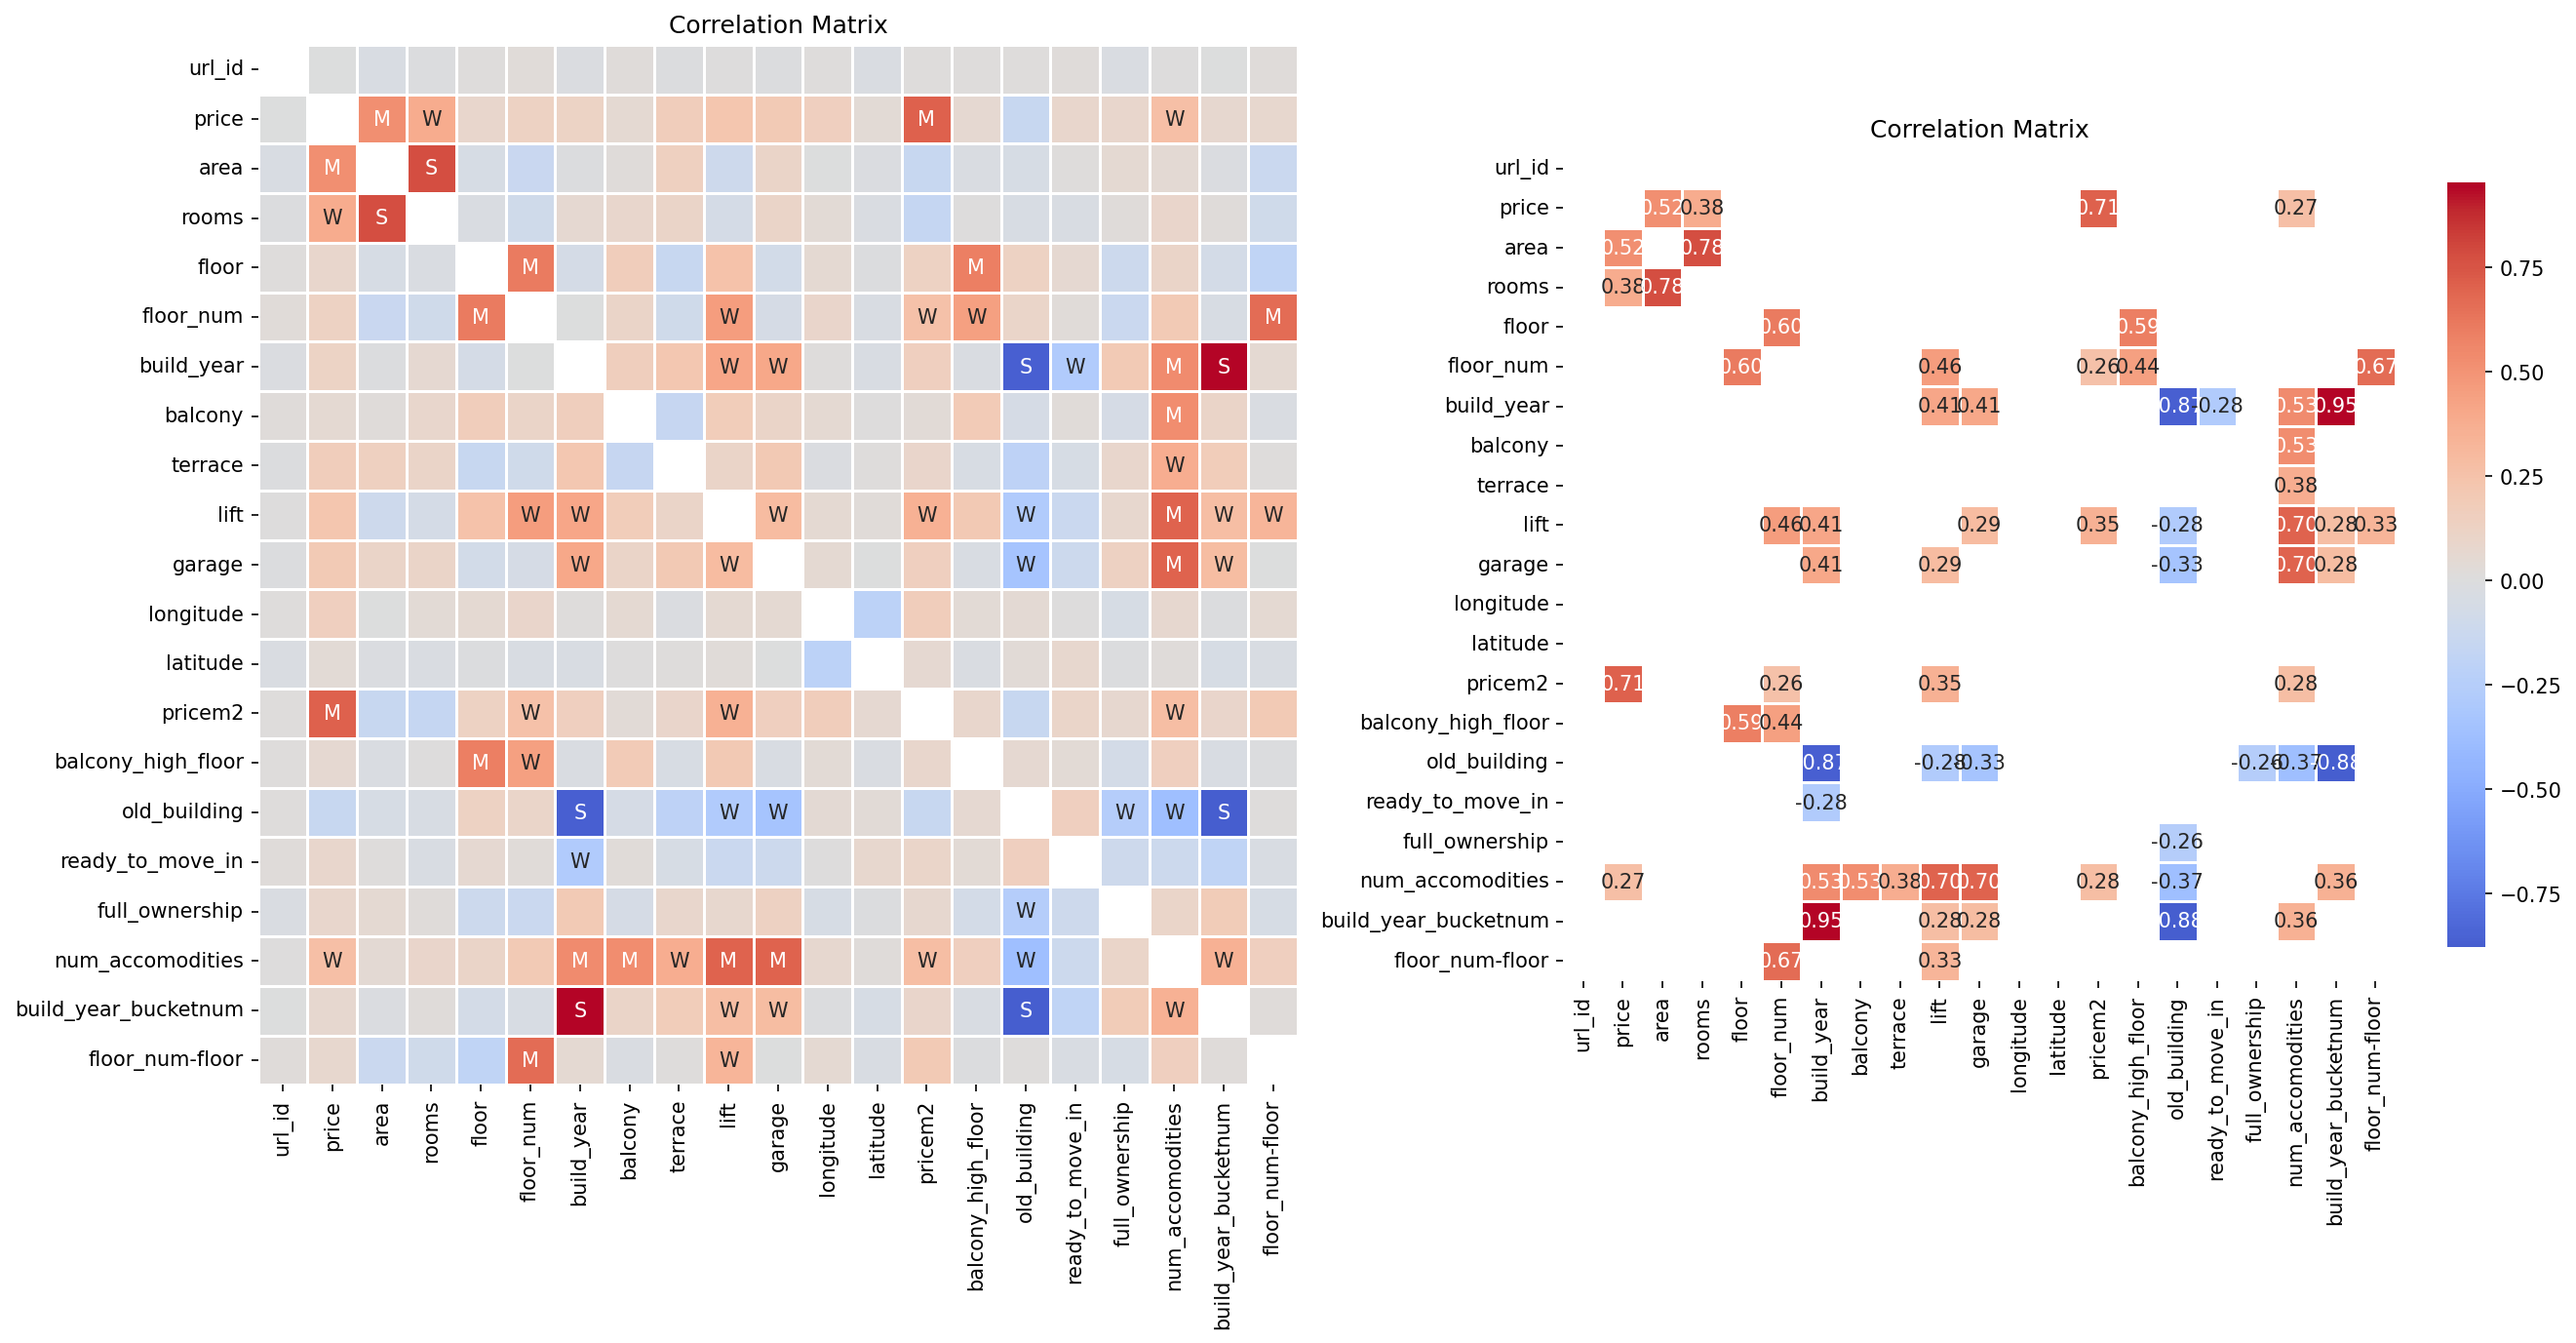

In [27]:
df_cor = df.select_dtypes("number").corr()
labels = np.where(np.abs(df_cor)>0.75, f"S",
                  np.where(np.abs(df_cor)>0.5, "M",
                           np.where(np.abs(df_cor)>0.25, "W", "")))

mask = np.where(np.abs(df_cor) > 0.25, False, True) - np.eye(len(df_cor))

fig, axes = plt.subplots(figsize=(18, 10), nrows=1, ncols=2, dpi=150)
sns.heatmap(df_cor,
            mask=np.eye(len(df_cor)), 
            square=True, 
            center=0, 
            annot=labels, 
            fmt="", 
            linewidths=0.5,
            cmap="coolwarm",
            cbar=False,
            ax=axes[0])
axes[0].set_title("Correlation Matrix")

sns.heatmap(df_cor,
            mask=mask, 
            square=True, 
            center=0, 
            annot=True, 
            fmt=".2f", 
            linewidths=0.5,
            cmap="coolwarm",
            cbar_kws={"shrink": 0.6},
            ax=axes[1])

axes[1].set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [16]:
X_select = df.select_dtypes("number").drop(columns=["price", "pricem2", "url_id"])
isna = X_select.isna()
X_select = X_select[~isna.any(axis=1)]
y_select = df["price"].loc[X_select.index]

print(X_select.shape, y_select.shape)

(116847, 17) (116847,)


In [17]:
rf_select = RandomForestRegressor(n_estimators=100, random_state=42)
rf_select.fit(X_select, y_select)

RandomForestRegressor(random_state=42)

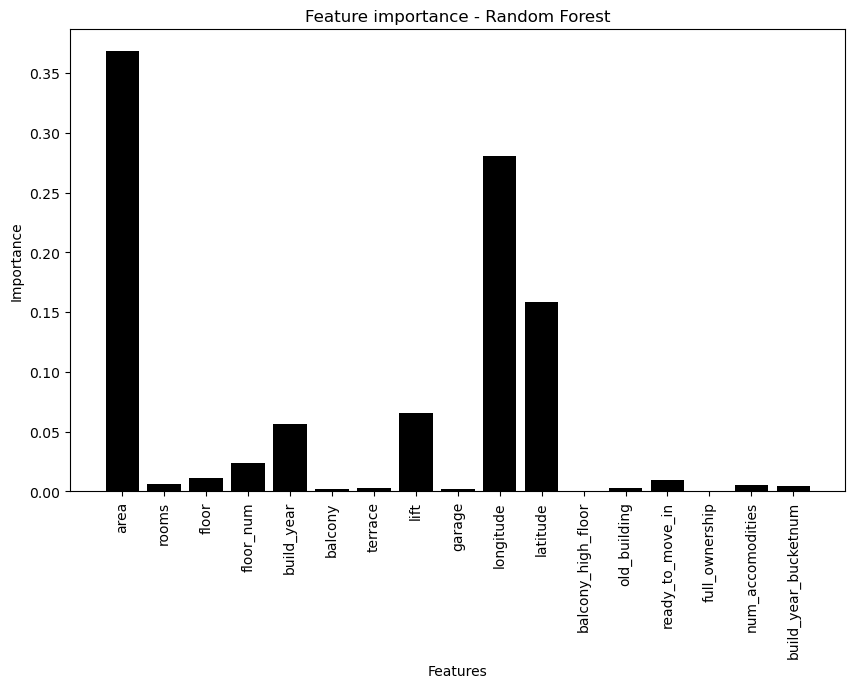

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(rf_select.feature_names_in_, rf_select.feature_importances_, color="black")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature importance - Random Forest")
plt.show()

<Figure size 1000x600 with 0 Axes>

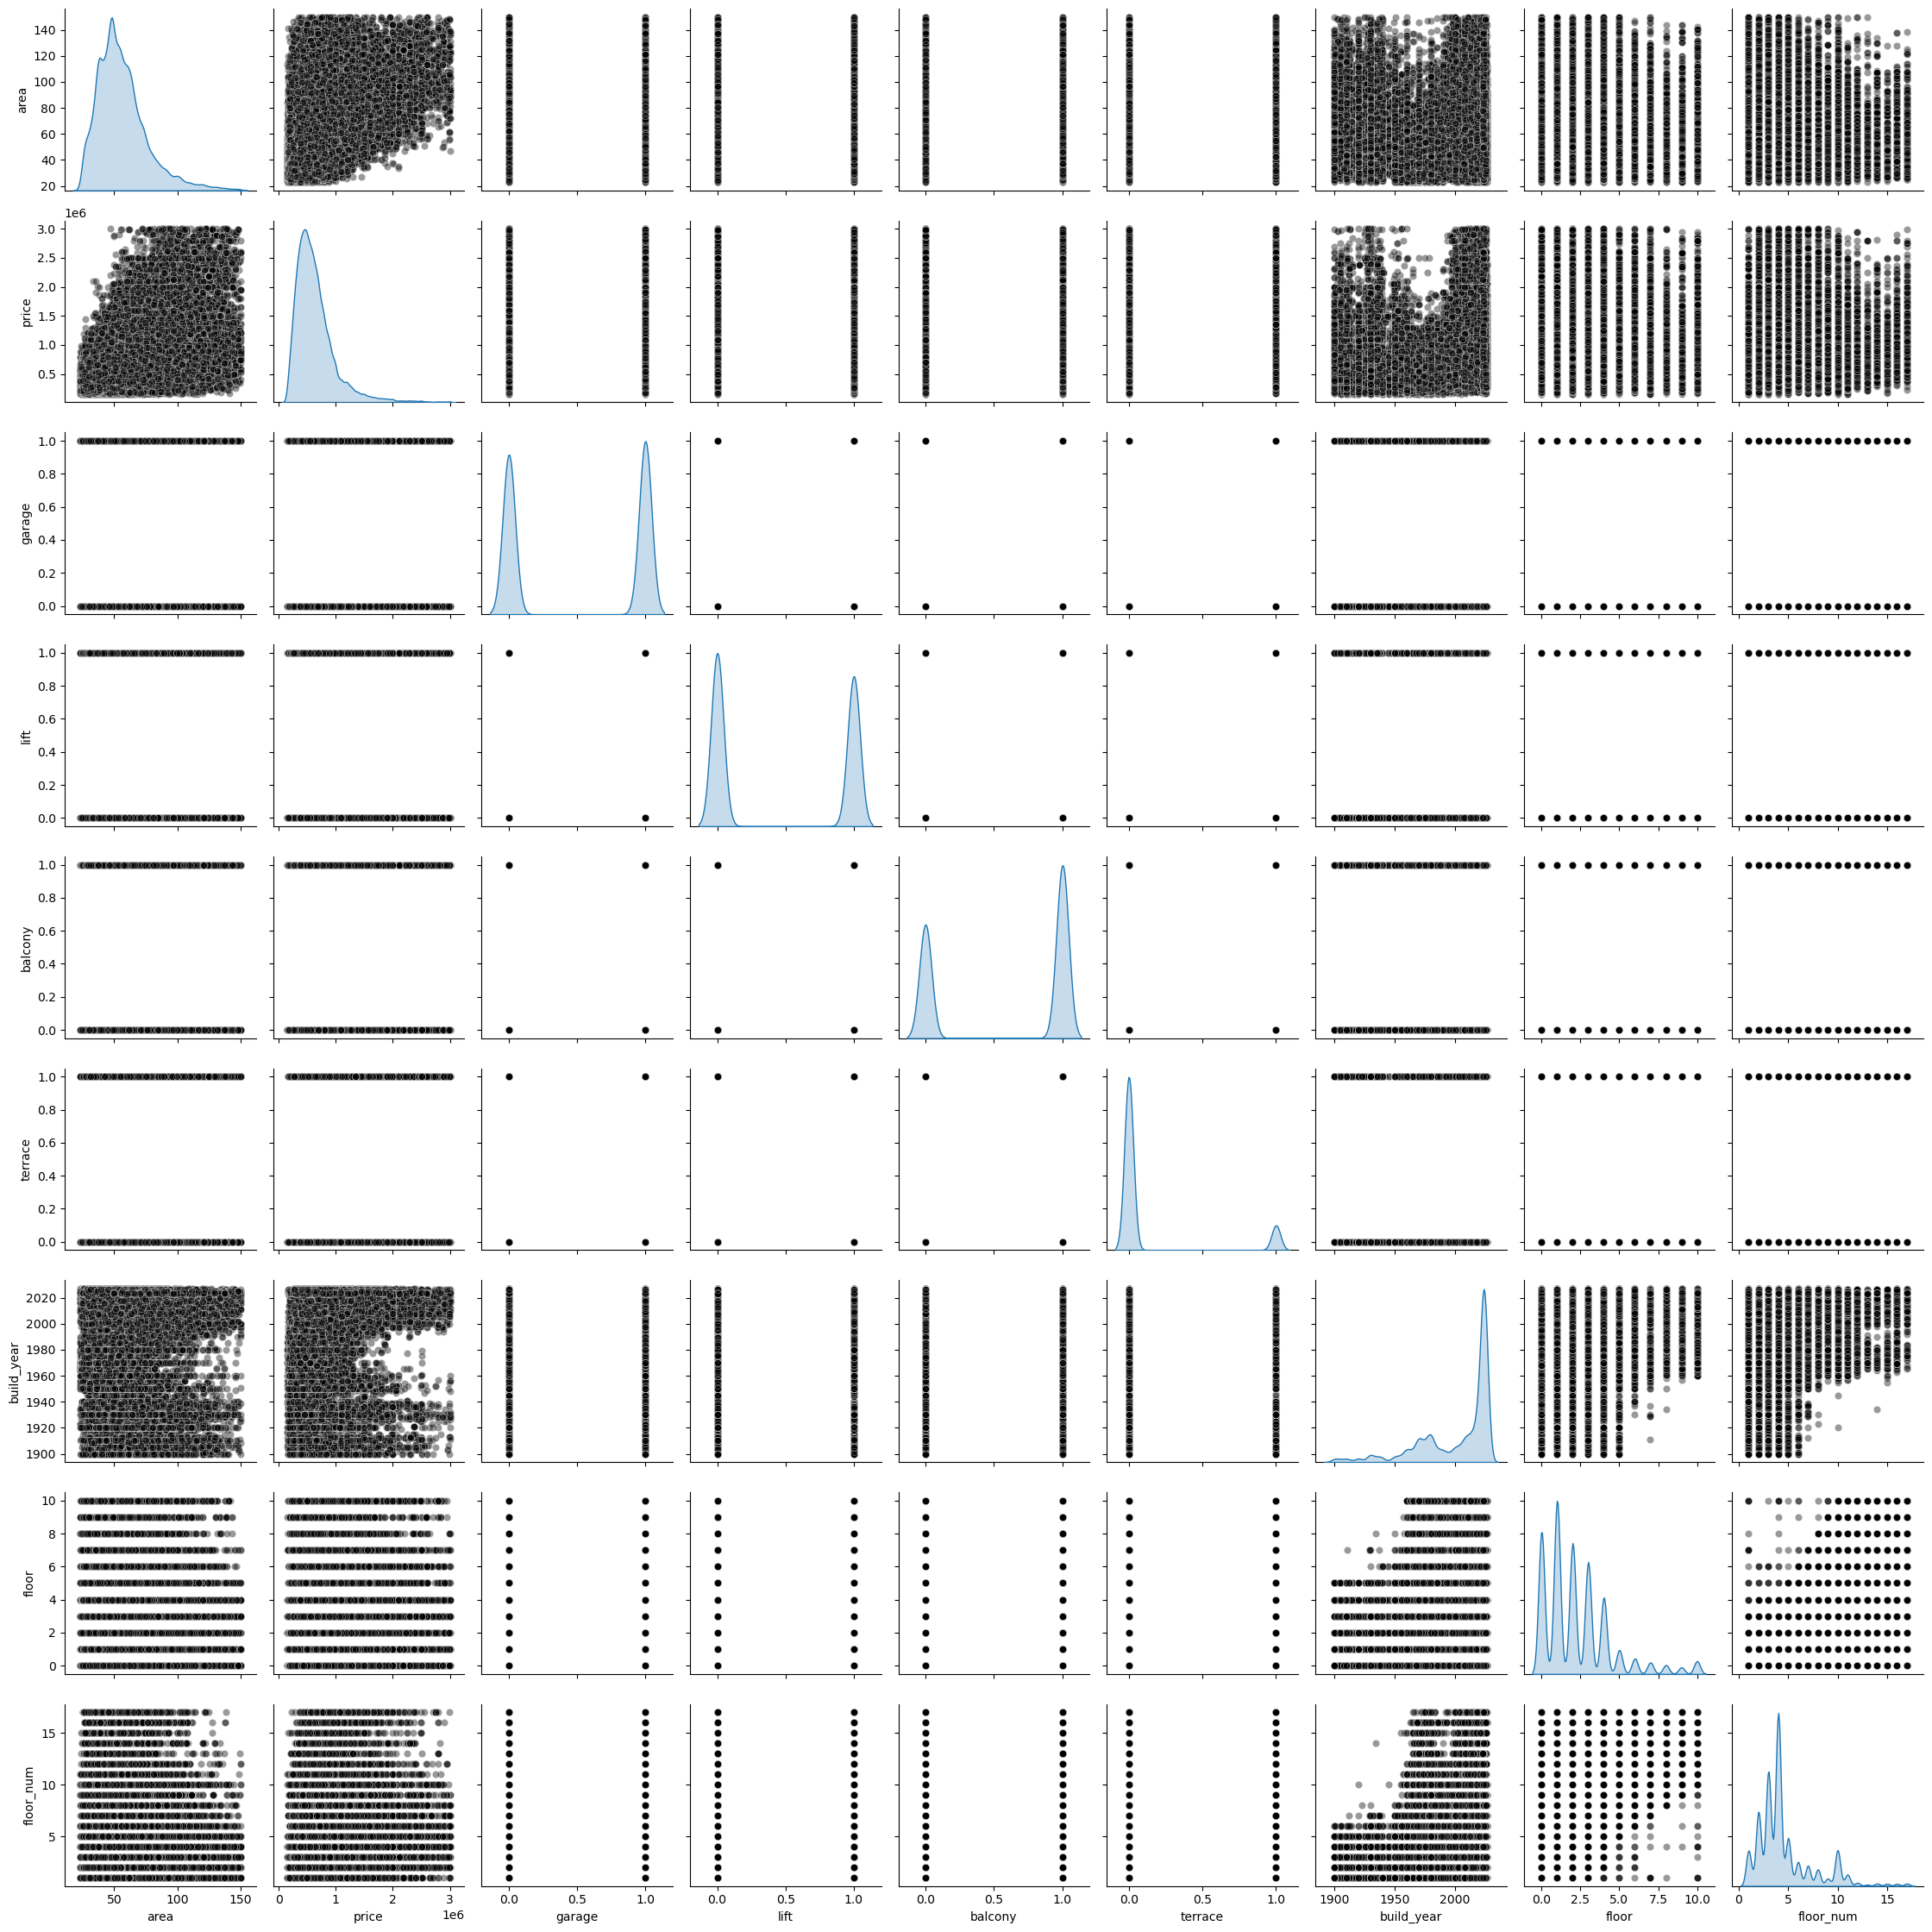

In [32]:
plt.figure(figsize=(10, 6))
sns.pairplot(data=df.select_dtypes("number"), vars=["area", "price", "garage", "lift", "balcony", "terrace", "build_year", "floor", "floor_num"], diag_kind="kde", plot_kws={"color": "black", "alpha": 0.4})
plt.tight_layout()
plt.show()

# todo:

floors:<br>
- floor_num < floor - FIX
- add feature with balcony on a high floor
build_year:<br>
- bucket

